# Dec 4, 2024: community profile variability
- does a community look the same across modes, across animals? 
- how large is the stable/consistent set of rois per community?

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from scipy.spatial.distance import jensenshannon, squareform, pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import cosine_similarity
from multiprocessing import Pool
import glob
import random

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

import arviz as az

import ants
from nipype.interfaces import afni

from itertools import product, combinations, chain
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [3]:
args.type = 'allen' #'spatial'
args.roi_size = 'x' #225
args.maintain_symmetry = True #True
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson-corr'
args.THRESHOLDING = f'positive'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results_v2/{PARC_DESC}'
TS_path = f'{ROI_path}/runwise_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
RSN_ROI_path = f'{ROI_path}/rsns'
os.system(f'mkdir -p {RSN_ROI_path}')
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
args.dc, args.sbm = False, 'h'

args.nested = True if args.sbm in ['h'] else False

args.force_niter = 40000
args.num_draws = int((1/2) * args.force_niter)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [6]:
def get_membership_matrix(num_rois, df, col='pi'):
    pis = [np.zeros((num_rois, 1)) if np.isnan(pi).all() else pi for pi in df[col]]

    num_modes = len(df)
    num_comms = np.max([pi.shape[-1] for pi in pis])
    num_rois = num_rois
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix

    for idx_mode, pi in enumerate(pis):
        M[:, idx_mode, :pi.shape[-1]] = pi
    
    return M

In [7]:
marginals_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl', recursive=True))
marginals_df = []
for sbm_file in marginals_files:
    with open(f'{sbm_file}', 'rb') as f:
        row = pickle.load(f)
    marginals_df += [row]
marginals_df = pd.concat(marginals_df).reset_index(drop=True)
mode_ids = list(chain.from_iterable([list(range(count)) for count in marginals_df['sub'].value_counts().sort_index().to_list()]))
marginals_df['mode_id'] = mode_ids
marginals_df

,sub,sbm,pi_0,pi_1,pi_2,pi_3,pi_4,pi_5,pi_6,pi_7,pi_8,omega,mode_id
0,SLC01,sbm-nd-h,"[[0.9901153212520593, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8813838550247117, 0.0032948929159802307, 0...","[[0.957166392092257, 0.026359143327841845, 0.0...","[[0.9868204283360791, 0.013179571663920923], [...","[[0.9983525535420099, 0.0016474464579901153], ...","[[0.9983525535420099, 0.0016474464579901153], ...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,0.607440,0
1,SLC01,sbm-nd-h,"[[0.9892857142857143, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9142857142857143, 0.0, 0.0, 0.0, 0.0857142...","[[0.9357142857142857, 0.039285714285714285, 0....","[[0.9857142857142858, 0.014285714285714285], [...","[[0.9964285714285714, 0.0035714285714285713], ...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,0.280320,1
2,SLC01,sbm-nd-h,"[[0.16964285714285715, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.7142857142857143, 0.0, 0.0, 0.0, 0.25, 0.0...","[[0.9107142857142857, 0.07142857142857142, 0.0...","[[0.9910714285714286, 0.008928571428571428], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,0.112240,2
3,SLC02,sbm-nd-h,"[[0.9901153212520593, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8813838550247117, 0.0032948929159802307, 0...","[[0.957166392092257, 0.026359143327841845, 0.0...","[[0.9868204283360791, 0.013179571663920923], [...","[[0.9983525535420099, 0.0016474464579901153], ...","[[0.9983525535420099, 0.0016474464579901153], ...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,0.505160,0
4,SLC02,sbm-nd-h,"[[0.9892857142857143, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9142857142857143, 0.0, 0.0, 0.0, 0.0857142...","[[0.9357142857142857, 0.039285714285714285, 0....","[[0.9857142857142858, 0.014285714285714285], [...","[[0.9964285714285714, 0.0035714285714285713], ...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,0.338587,1
5,SLC02,sbm-nd-h,"[[0.16964285714285715, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.7142857142857143, 0.0, 0.0, 0.0, 0.25, 0.0...","[[0.9107142857142857, 0.07142857142857142, 0.0...","[[0.9910714285714286, 0.008928571428571428], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,0.156253,2
6,SLC03,sbm-nd-h,"[[0.9901153212520593, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8813838550247117, 0.0032948929159802307, 0...","[[0.957166392092257, 0.026359143327841845, 0.0...","[[0.9868204283360791, 0.013179571663920923], [...","[[0.9983525535420099, 0.0016474464579901153], ...","[[0.9983525535420099, 0.0016474464579901153], ...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,0.161628,0
7,SLC03,sbm-nd-h,"[[0.9892857142857143, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9142857142857143, 0.0, 0.0, 0.0, 0.0857142...","[[0.9357142857142857, 0.039285714285714285, 0....","[[0.9857142857142858, 0.014285714285714285], [...","[[0.9964285714285714, 0.0035714285714285713], ...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,0.155390,1
8,SLC03,sbm-nd-h,"[[0.16964285714285715, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.7142857142857143, 0.0, 0.0, 0.0, 0.25, 0.0...","[[0.9107142857142857, 0.07142857142857142, 0.0...","[[0.9910714285714286, 0.008928571428571428], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,0.143074,2
9,SLC03,sbm-nd-h,"[[0.9405940594059405, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9821782178217822, 0.0, 0.0, 0.0, 0.0138613...","[[0.9465346534653465, 0.033663366336633666, 0....","[[0.9900990099009901, 0.009900990099009901, 0....","[[0.996039603960396, 0.0039603960396039604], [...","[[1.0, 0.0], [1.0, 0.0], [0.998019801980198, 0...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,0.124680,3


In [8]:
cols = [col for col in  list(marginals_df.columns) if 'pi_' in col]
cols

['pi_0', 'pi_1', 'pi_2', 'pi_3', 'pi_4', 'pi_5', 'pi_6', 'pi_7', 'pi_8']

In [9]:
# SOFT MARGINALS
soft_marginals_df = []
for sub, group in marginals_df.groupby('sub'):
    omegas = group['omega'].to_list()
    dct = {'sub': [sub], 'sbm': [SBM]}
    for col in cols:
        M = get_membership_matrix(args.num_rois, group, col=col)
        SCs = np.average(M, axis=1, weights=omegas) # soft-comms.
        dct[col] = [SCs]
    soft_marginals_df += [pd.DataFrame(dct)]
soft_marginals_df = pd.concat(soft_marginals_df).reset_index(drop=True)
soft_marginals_df

,sub,sbm,pi_0,pi_1,pi_2,pi_3,pi_4,pi_5,pi_6,pi_7,pi_8
0,SLC01,sbm-nd-h,"[[0.8977929364556366, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8718518088962108, 0.0020014497528830313, 0...","[[0.9459391532125205, 0.035041312308778536, 0....","[[0.9869874867027537, 0.013012513297246411], [...","[[0.9979981322664156, 0.002001867733584373], [...","[[0.8867592751235585, 0.0010007248764415156], ...","[[0.60744], [0.60744], [0.60744], [0.60744], [...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
1,SLC02,sbm-nd-h,"[[0.8616335531836663, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.866414497438449, 0.0016644494656771884, 0....","[[0.9426447281233193, 0.03777812415626341, 0.0...","[[0.9871101321431203, 0.012889867856879716], [...","[[0.9979585356708509, 0.0020414643291491565], ...","[[0.8429152750671455, 0.0008322247328385942], ...","[[0.5051604128330267], [0.5051604128330267], [...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
2,SLC03,sbm-nd-h,"[[0.7347218143727945, 0.0, 0.01904950922275958...","[[0.8027296121914562, 0.09455013968026232, 0.0...","[[0.8805463280375332, 0.056739282130032, 0.0, ...","[[0.9787149023468772, 0.019748842924379402, 0....","[[0.9979020767759192, 0.0020979232240807954], ...","[[0.8163130106637612, 0.0006255689907493272], ...","[[0.5958893154190659, 0.0], [0.595350722336753...","[[0.2119321817018554, 0.0], [0.211393588619543...","[[0.08725207933461292], [0.08725207933461292],..."
3,SLC04,sbm-nd-h,"[[0.9459125043909121, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8863237124765099, 0.0017297001457630258, 0...","[[0.9456396553691001, 0.03421771912783523, 0.0...","[[0.9865813022905506, 0.01341869770944947], [0...","[[0.9976294804485735, 0.002370519551426652], [...","[[0.9456865981588357, 0.0008648500728815129], ...","[[0.5249639942390784], [0.5249639942390784], [...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
4,SLC05,sbm-nd-h,"[[0.8130407774443612, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.874092392812236, 0.0012080019852788717, 0....","[[0.9404885581915815, 0.040065316915495336, 0....","[[0.9880332791031377, 0.011966249222332899, 2....","[[0.9977904353375576, 0.002209564662442389], [...","[[0.7951267313386685, 0.0006040009926394359], ...","[[0.5538055644387593, 0.0], [0.553805564438759...","[[0.18724016629357212], [0.18724016629357212],...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
5,SLC06,sbm-nd-h,"[[0.8973256100813988, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8729552523304034, 0.0018802736107749298, 0...","[[0.9451368866106166, 0.03553384231794725, 0.0...","[[0.9869496611469873, 0.013050338853012768], [...","[[0.9979292773923479, 0.002070722607652064], [...","[[0.8862869286988916, 0.0009401368053874649], ...","[[0.5706630408701912], [0.5706630408701912], [...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
6,SLC07,sbm-nd-h,"[[0.916710109513164, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.8846781446861861, 0.0014928319833808522, 0...","[[0.9436751094882899, 0.03600391625820136, 0.0...","[[0.9868477994721776, 0.01315172866466849, 2.3...","[[0.9975946356212689, 0.002405364378731002], [...","[[0.9125543918144361, 0.0007464159916904261], ...","[[0.49172198672318645, 0.0], [0.49172198672318...","[[0.03871070942973686], [0.03871070942973686],...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
7,SLC08,sbm-nd-h,"[[0.8483587803360707, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8785646411340852, 0.0013375125218844722, 0...","[[0.9419809372493975, 0.03843527216566195, 0.0...","[[0.9877036299233776, 0.012296370076622522, 0....","[[0.9977338981828051, 0.0022661018171949614], ...","[[0.8359973771577107, 0.0006687562609422361], ...","[[0.5576707726763718, 0.0], [0.557670772676371...","[[0.1517357222844345], [0.1517357222844345], [...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
8,SLC09,sbm-nd-h,"[[0.8244173424603205, 0.0, 0.0, 0.0, 0.0, 0.0,..

unique configurations

In [10]:
def compute_distances(config_matrix):
    # config_matrix : num_modes x num_rois
    distances = pdist(config_matrix, metric='cosine')
    distances = np.nan_to_num(distances)
    dist_matrix = squareform(distances)
    return dist_matrix, distances

def perform_hierarchical_clustering(distances, threshold=0.1):
    Z = linkage(distances, method='average')
    clusters = fcluster(Z, t=threshold, criterion='distance')
    return Z, clusters

def compute_cluster_probabilities(clusters, omegas):
    return np.bincount(clusters-1, weights=omegas)

def compute_effective_number_of_configs(probs):
    return np.exp(stats.entropy(probs))

def get_unique_configs(config_matrix, clusters):
    # encdr : num_modes x num_clusters
    encdr = OneHotEncoder(
        sparse_output=False,
    ).fit_transform(clusters.reshape(-1, 1))
    # mean configuration within each cluster, 
    # config_matrix.T : num_rois x num_modes
    # cluster_configs : num_rois x num_clusters (per comm)
    unique_configs =  np.round(
        config_matrix.T @ encdr / encdr.sum(axis=0),
        decimals=3,
    )
    return unique_configs

def sort_cluster_results(cluster_probs, unique_configs):
    sort_idx = np.argsort(cluster_probs)[::-1] # decreasing order
    sorted_probs = cluster_probs[sort_idx]
    sorted_configs = unique_configs[:, sort_idx]
    return sorted_probs, sorted_configs

def analyze_configs_per_comm(config_matrix, omegas, threshold=0.1):
    dist_mat, dists = compute_distances(config_matrix)
    Z, clusters = perform_hierarchical_clustering(dists, threshold)
    cluster_probs = compute_cluster_probabilities(clusters, omegas)
    eff_num_configs = compute_effective_number_of_configs(cluster_probs)
    unique_configs = get_unique_configs(config_matrix, clusters)
    cluster_probs, unique_configs = sort_cluster_results(cluster_probs, unique_configs)

    return (
        clusters - 1, 
        eff_num_configs,
        cluster_probs,
        unique_configs,
        dist_mat,
    )

def analyze_configs_per_col(args, sub, SBM, col, M, omegas, threshold=0.1):  
    num_rois, num_modes, num_comms = M.shape
    col_df = []
    for comm in range(num_comms):
        (
            clusters,
            eff_num_configs, 
            cluster_strengths, 
            unique_configs,
            dist_mat,
        ) = analyze_configs_per_comm(M[:, :, comm].T, omegas, threshold=threshold)
        crow = pd.DataFrame(dict(
            sub=[sub],
            sbm=[SBM],
            col=[col],
            comm=[comm],
            clusters=[clusters],
            eff_num_configs=[eff_num_configs],
            strengths=[cluster_strengths],
            configs=[unique_configs],
            distance_matrix=[dist_mat],
        ))
        col_df += [crow]
    col_df = pd.concat(col_df).reset_index(drop=True)
    return col_df

def analyze_configs_per_sub(args, sub, SBM, cols, group, threshold=0.1):
    configs_sub_df = []
    for col in cols:
        M = get_membership_matrix(args.num_rois, group, col)
        omegas = group['omega'].to_numpy()
        col_df = analyze_configs_per_col(args, sub, SBM, col, M, omegas, threshold=threshold)
        configs_sub_df += [col_df]
    return pd.concat(configs_sub_df).reset_index(drop=True)

In [11]:
analysis_df = []
threshold = 0.18 # threshold based on eff_num of amygdala (comm 14).
for sub, group in tqdm(marginals_df.groupby('sub')):
    analysis_df += [analyze_configs_per_sub(args, sub, SBM, cols, group, threshold)]
analysis_df = pd.concat(analysis_df).reset_index(drop=True)

100%|██████████| 10/10 [00:01<00:00,  9.36it/s]


In [12]:
analysis_df

,sub,sbm,col,comm,clusters,eff_num_configs,strengths,configs,distance_matrix
0,SLC01,sbm-nd-h,pi_0,0,"[0, 0, 1]",1.420733,"[0.88776, 0.11224]","[[0.99, 0.17], [0.0, 0.0], [0.0, 0.0], [0.0, 0...","[[0.0, 1.0366830287877882e-05, 0.4165092683332..."
1,SLC01,sbm-nd-h,pi_0,1,"[0, 0, 0]",1.000000,[1.0],"[[0.0], [0.996], [0.0], [0.0], [0.0], [0.0], [...","[[0.0, 0.004436033534841122, 0.016161628185739..."
2,SLC01,sbm-nd-h,pi_0,2,"[0, 0, 0]",1.000000,[1.0],"[[0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0....","[[0.0, 3.632055659685829e-05, 0.00023843010765..."
3,SLC01,sbm-nd-h,pi_0,3,"[0, 0, 0]",1.000000,[1.0],"[[0.0], [0.004], [0.0], [1.0], [0.002], [0.478...","[[0.0, 0.0013710860772255806, 0.00451748735214..."
4,SLC01,sbm-nd-h,pi_0,4,"[0, 0, 0]",1.000000,[1.0],"[[0.0], [0.0], [0.0], [0.0], [0.987], [0.495],...","[[0.0, 0.00548106404990345, 0.0171747619607044..."
...,...,...,...,...,...,...,...,...,...
795,SLC10,sbm-nd-h,pi_6,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.000000,[1.0],"[[0.5], [0.499], [0.499], [0.499], [0.499], [0...","[[0.0, 0.0, 0.0, 2.272345365206263e-07, 0.0, 0..."
796,SLC10,sbm-nd-h,pi_6,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.000000,[1.0],"[[0.0], [0.001], [0.001], [0.001], [0.001], [0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
797,SLC10,sbm-nd-h,pi_7,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.000000,[1.0],"[[0.2], [0.199], [0.199], [0.199], [0.199], [0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
798,SLC10,sbm-nd-h,pi_7,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.000000,[1.0],"[[0.0], [0.001], [0.001], [0.001], [0.001], [0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [13]:
Ds = analysis_df[
    (analysis_df['col'] == 'pi_0')
    & (analysis_df['comm'] == 14)
]['distance_matrix'].to_list()

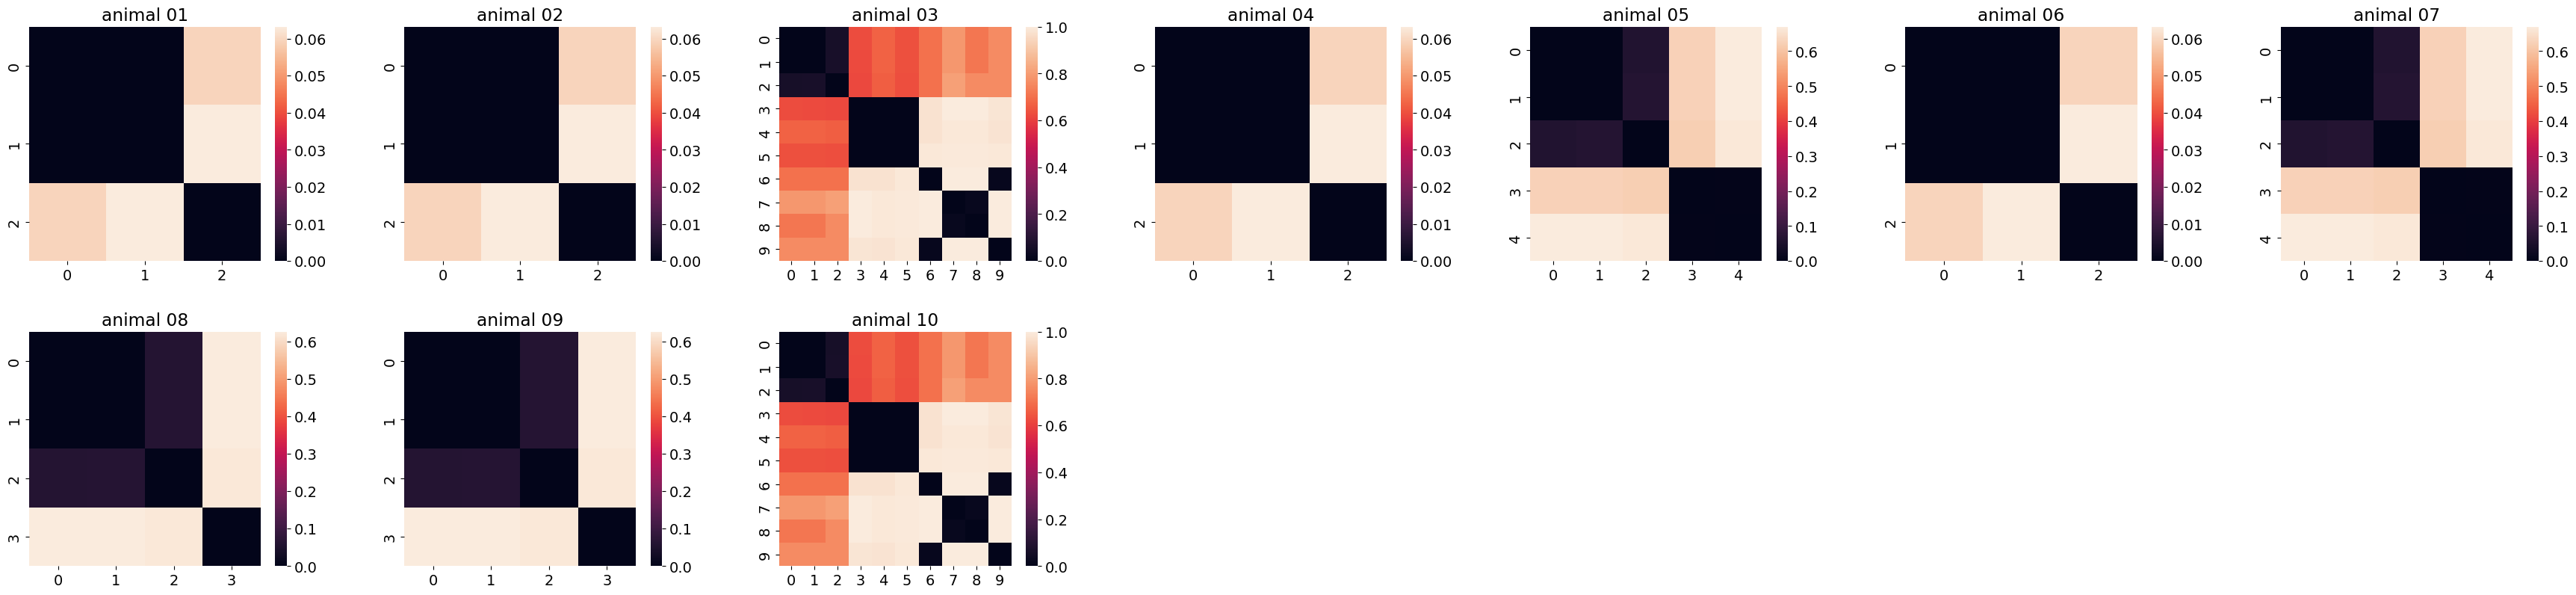

In [14]:
ncols = 7
nrows = np.ceil(len(Ds) / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
fig.tight_layout(h_pad=3, w_pad=3)
for idx, D in enumerate(Ds):
    r, c = idx // ncols, idx % ncols
    ax = axs[r, c] if nrows > 1 else axs[c]
    sns.heatmap(D, ax=ax)
    ax.set(title=f'animal {idx+1:02d}')
for c_ in range(c+1, ncols):
    ax = axs[r, c_] if nrows > 1 else axs[c_]
    fig.delaxes(ax)

group statistics

In [15]:
def bootstrap_ci(data, statistic=np.median, n_boot=10000, conf=0.95):
    boots = [statistic(np.random.choice(data, len(data), replace=True)) 
             for _ in range(n_boot)]
    mean = statistic(data)
    ci = np.percentile(boots, [(1-conf)*50, (1+conf)*50])
    return mean, ci

In [16]:
group_df = []
for (col, comm), group in tqdm(analysis_df.groupby(by=['col', 'comm'])):
    # if (not col == 'pi_0') | (not comm == 2): continue
    encs = group['eff_num_configs'].to_list()
    m, ci = bootstrap_ci(encs, )
    Ss = get_membership_matrix(1, group, 'strengths')
    Ss = Ss[0, :, :]
    Cs = get_membership_matrix(args.num_rois, group, 'configs')
    row = pd.DataFrame(dict(
        sbm=[SBM],
        col=[col],
        comm=[comm],
        encs=[encs],
        mean=[m],
        cil=[ci[0]],
        ciu=[ci[1]],
        strengths=[Ss],
        configs=[Cs],
    ))
    group_df += [row]
group_df = pd.concat(group_df).reset_index(drop=True)

100%|██████████| 86/86 [00:31<00:00,  2.75it/s]


In [17]:
group_df

,sbm,col,comm,encs,mean,cil,ciu,strengths,configs
0,sbm-nd-h,pi_0,0,"[1.4207332644015318, 1.5424978602521526, 4.308...",1.948001,1.422298,3.085645,"[[0.88776, 0.11224, 0.0, 0.0, 0.0, 0.0], [0.84...","[[[0.99, 0.17, 0.0, 0.0, 0.0, 0.0], [0.99, 0.1..."
1,sbm-nd-h,pi_0,1,"[1.0, 1.0, 3.472011784914423, 1.0, 1.619817821...",1.354492,1.000000,2.208668,"[[1.0, 0.0, 0.0, 0.0, 0.0], [0.999999999999999...","[[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0..."
2,sbm-nd-h,pi_0,2,"[1.0, 1.0, 2.5458707299706207, 1.0, 1.61981782...",1.354492,1.000000,1.906632,"[[1.0, 0.0, 0.0], [0.9999999999999999, 0.0, 0....","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.054, 0...."
3,sbm-nd-h,pi_0,3,"[1.0, 1.0, 3.2372820859949223, 1.0, 1.61981782...",1.354492,1.000000,2.150272,"[[1.0, 0.0, 0.0, 0.0], [0.9999999999999999, 0....","[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
4,sbm-nd-h,pi_0,4,"[1.0, 1.0, 3.8539065795245815, 1.0, 1.61981782...",1.354492,1.000000,2.336029,"[[1.0, 0.0, 0.0, 0.0, 0.0], [0.999999999999999...","[[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0..."
...,...,...,...,...,...,...,...,...,...
81,sbm-nd-h,pi_6,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,1.000000,1.000000,"[[1.0], [0.9999999999999999], [1.0], [0.999999...","[[[0.333], [0.333], [0.5], [0.333], [0.6], [0...."
82,sbm-nd-h,pi_6,1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,1.000000,1.000000,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [..."
83,sbm-nd-h,pi_7,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,1.000000,1.000000,"[[1.0], [0.9999999999999999], [1.0], [0.999999...","[[[0.0], [0.0], [0.2], [0.0], [0.2], [0.0], [0..."
84,sbm-nd-h,pi_7,1,"[1.0, 1.0]",1.000000,1.000000,1.000000,"[[1.0], [1.0]]","[[[0.0], [0.0]], [[0.001], [0.001]], [[0.001],..."


In [18]:
# eff num configs

In [19]:
def plot_eff_num_configs(group, SBM, col):
    fig, axs = plt.subplots(1, 1, figsize=(20, 5))
    ax = axs

    df = group[['comm', 'encs']].explode('encs')
    sns.stripplot(
        data=df, 
        x='comm', y='encs', ax=ax,
        alpha=0.5, color='cornflowerblue', size=5,
    )
    sns.boxplot(
        data=df, 
        x='comm', y='encs', ax=ax,
        color='grey', fill=False, showfliers=0,
    )

    ax.scatter(
        range(len(group)), group['mean'], 
        c='salmon', marker='o', s=50, label='median'
    )
    ax.vlines(
        range(len(group)), group['cil'], group['ciu'], 
        color='cornflowerblue', linewidth=15, alpha=0.3, label='95% CI'
    )

    ax.fill_between(
        x=np.arange(-0.5, len(group)+0.5),
        y1=1,
        y2=1.5,
        color='forestgreen', alpha=0.15,
        label=f'~1',
    )
    ax.fill_between(
        x=np.arange(-0.5, len(group)+0.5),
        y1=1.5,
        y2=2.5,
        color='darkorange', alpha=0.15,
        label=f'~2',
    )
    ax.fill_between(
        x=np.arange(-0.5, len(group)+0.5),
        y1=4,
        y2=2.5,
        color='indianred', alpha=0.15,
        label=f'>2',
    )

    ax.set_xticklabels([f'{i:02d}' for i in range(len(group))])
    ax.set(ylabel=f'effective #configurations', xlim=[-0.65, len(group)], title=f'{SBM} {col}')
    ax.grid(alpha=0.2)
    ax.legend()
    return fig

In [20]:
folder = f'{ESTIM_path}/group/community-configurations/{SBM}'
os.system(f'mkdir -p {folder}')

for col, group in group_df.groupby('col'):
    if int(col.split('_')[-1]) > 1: continue
    fig = plot_eff_num_configs(group, SBM, col)
    fig.savefig(f'{folder}/{col}_desc-eff-num-configs.pdf', bbox_inches='tight')
    plt.close('all')

In [21]:
# cluster_strengths

In [22]:
def plot_strengths(group, SBM, col):
    ncols = 7
    nrows = np.ceil(len(group) / ncols).astype(int)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), sharey=True)
    fig.tight_layout(h_pad=3, w_pad=3)
    fig.suptitle(f'{SBM} {col}', x=0.0, y=1.0)
    for idx_comm, row in group.iterrows():
        r, c = idx_comm // ncols, idx_comm % ncols
        ax = axs[r, c] if nrows > 1 else axs[c]

        sns.barplot(row['strengths'], ax=ax, color='grey', alpha=0.3)
        sns.stripplot(row['strengths'], ax=ax, color='cornflowerblue')
        ax.set(title=f'comm {idx_comm:02d}', xlabel=f'configuration', ylabel=f'strength')
        ax.grid(alpha=0.2)

    for c_ in np.arange(c+1, ncols):
        ax = axs[r, c_] if nrows > 1 else axs[c_]
        fig.delaxes(ax)

    return fig

In [23]:
folder = f'{ESTIM_path}/group/community-configurations/{SBM}'
os.system(f'mkdir -p {folder}')

for col, group in group_df.groupby('col'):
    if (int(col.split('_')[-1]) > 1): continue
    group = group.reset_index(drop=True)
    fig = plot_strengths(group, SBM, col)
    fig.savefig(f'{folder}/{col}_desc-cluster-strengths.pdf', bbox_inches='tight')
    plt.close('all')

In [24]:
# unique configs

In [25]:
def get_stable_fraction_per_sub(strengths, configs, tol=0.01):
    comm_mask = ~np.all(configs <= tol, axis=1)
    comm_size = np.sum(comm_mask)
    diffs = np.abs(configs[comm_mask] - configs[comm_mask][:, [0]])
    weighted_diffs = diffs * strengths
    stable_frac = np.sum(np.all(weighted_diffs <= tol, axis=1)) / np.sum(comm_mask)
    return np.nan_to_num(stable_frac)

def get_stable_fracs_per_comm(Ss, Cs, tol=0.01):
    stable_fracs = []
    for sub in range(Ss.shape[0]):
        strengths = Ss[sub, :]
        configs = Cs[:, sub, :]
        stable_fracs.append(get_stable_fraction_per_sub(strengths, configs, tol))
    return np.array(stable_fracs)

def get_stable_fracs_per_col(group, tol=0.01):
    sfrac_df = []
    for idx_comm, row in group.iterrows():
        stable_fracs = get_stable_fracs_per_comm(
            row['strengths'],
            row['configs'],
            tol,
        )
        m, ci = bootstrap_ci(stable_fracs, )
        df = pd.DataFrame(dict(
            sbm=[SBM],
            col=[col],
            comm=[row['comm']],
            stable_fracs=[stable_fracs],
            mean=[m],
            cil=[ci[0]],
            ciu=[ci[1]],
        ))
        sfrac_df += [df]
    sfrac_df = pd.concat(sfrac_df).reset_index(drop=True)
    return sfrac_df

In [26]:
tol = 0.01
sfrac_df = []
for col, group in tqdm(group_df.groupby('col')):
    group = group.reset_index(drop=True)
    col_df = get_stable_fracs_per_col(group, tol)
    sfrac_df += [col_df]
sfrac_df = pd.concat(sfrac_df).reset_index(drop=True)

100%|██████████| 9/9 [00:29<00:00,  3.25s/it]


In [27]:
sfrac_df

,sbm,col,comm,stable_fracs,mean,cil,ciu
0,sbm-nd-h,pi_0,0,"[0.05263157894736842, 0.05263157894736842, 0.0...",0.071770,0.047149,0.090909
1,sbm-nd-h,pi_0,1,"[1.0, 1.0, 0.2777777777777778, 1.0, 0.29166666...",0.375000,0.291667,1.000000
2,sbm-nd-h,pi_0,2,"[1.0, 1.0, 0.14285714285714285, 1.0, 0.4285714...",0.500000,0.303571,1.000000
3,sbm-nd-h,pi_0,3,"[1.0, 1.0, 0.12121212121212122, 1.0, 0.3333333...",0.354167,0.257576,1.000000
4,sbm-nd-h,pi_0,4,"[1.0, 1.0, 0.3333333333333333, 1.0, 0.15384615...",0.333333,0.153846,1.000000
...,...,...,...,...,...,...,...
81,sbm-nd-h,pi_6,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,1.000000,1.000000
82,sbm-nd-h,pi_6,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000000,0.000000
83,sbm-nd-h,pi_7,0,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",1.000000,0.000000,1.000000
84,sbm-nd-h,pi_7,1,"[0.0, 0.0]",0.000000,0.000000,0.000000


In [28]:
def plot_stable_fracs(group, SBM, col):
    fig, axs = plt.subplots(1, 1, figsize=(20, 5))
    ax = axs

    df = group[['comm', 'stable_fracs']].explode('stable_fracs')
    sns.stripplot(
        data=df, 
        x='comm', y='stable_fracs', ax=ax,
        alpha=0.5, color='cornflowerblue', size=5,
    )
    sns.boxplot(
        data=df, 
        x='comm', y='stable_fracs', ax=ax,
        color='grey', fill=False, showfliers=0,
    )

    ax.scatter(
        range(len(group)), group['mean'], 
        c='salmon', marker='o', s=50, label='median'
    )
    ax.vlines(
        range(len(group)), group['cil'], group['ciu'], 
        color='cornflowerblue', linewidth=15, alpha=0.3, label='95% CI'
    )

    ax.fill_between(
        x=np.arange(-0.5, len(group)+0.5),
        y1=0.0,
        y2=0.25,
        color='indianred', alpha=0.15,
        label=f'<25%',
    )
    ax.fill_between(
        x=np.arange(-0.5, len(group)+0.5),
        y1=0.25,
        y2=0.75,
        color='darkorange', alpha=0.15,
        label=f'~50%',
    )
    ax.fill_between(
        x=np.arange(-0.5, len(group)+0.5),
        y1=0.75,
        y2=1.0,
        color='forestgreen', alpha=0.15,
        label=f'>75%',
    )

    ax.set_xticklabels([f'{i:02d}' for i in range(len(group))])
    ax.set(ylabel=f'consistent fraction of rois', xlim=[-0.65, len(group)], title=f'{SBM} {col}')
    ax.grid(alpha=0.2)
    ax.legend()
    return fig

In [29]:
folder = f'{ESTIM_path}/group/community-configurations/{SBM}'
os.system(f'mkdir -p {folder}')

for col, group in sfrac_df.groupby('col'):
    if int(col.split('_')[-1]) > 1: continue
    fig = plot_stable_fracs(group, SBM, col)
    fig.savefig(f'{folder}/{col}_desc-stable-fracs.pdf', bbox_inches='tight')
    plt.close('all')